In [ ]:
# Notebook to compute in situ SMOD from Météo-France data

In [ ]:
Le CEN a reconstitué les séries de hauteur de neige pour 665 postes (Alpes, Pyrénées (FR/ES), Corse) avec la réanalyse S2M.

- DSN_T_ISBA_obs = observations
- DSN_T_ISBA_Crocus = modèle
- DSN_T_ISBA_Crocus_assim = modèle corrigé avec les observations

## Functions

In [1]:
import os
import pandas as pd
from datetime import datetime
import itertools, operator
import numpy as np
import xml.etree.ElementTree as ET 
from matplotlib import pyplot as plt
from glob import glob
from calendar import isleap
import seaborn as sn

In [2]:
def get_station_metadata(tree, station_id):
    '''
    Returns a dictionnary of useful metadata from a station ID (str)
    '''
    n = station_id.zfill(8)
    s = tree.find(f".//Site/[number=' {n} ']")
    d = dict()
    # strings
    for tag in ['name']:
        v = s.find(tag).text
        d[tag] = v
    # floats
    for tag in ['lat','lon', 'altitude']:
        v = s.find(tag).text
        d[tag] = float(v)
    return d

In [3]:
def add_waterdate(df):
    '''
    Appends a water year column ('wy') to a series dataframe (index = date object) and other useful dates-related columns ('doy', 'dowy', 'datewy', etc.)
    '''
    dt = df.index
    df['date'] = dt
    df['doy'] = dt.dayofyear #day_of_year
    df['year'] = dt.year
    # add water year (labeled with 1st year of water year)
    df['wy'] = df[['doy','year']].apply(axis=1, func = lambda x: (x[1] - (x[0] < 244 + isleap(x[1]))), raw=True)
    df['dowy'] = df[['doy','year','wy']].apply(axis=1, func = lambda x: (x[0] + 122*(x[1] > x[2]) - (243+isleap(x[1]))*(x[1] == x[2])  ), raw=True) #day_of_wateryear
    return df.drop('date',axis=1)

In [4]:
def get_station_data(station_id, min_year = 1985, max_year = 2019): 
    '''
    Returns a dataframe of the snow depth time series at this station
    '''
    f = glob(f'data/output_*_{int(station_id)}.txt')[0]
    df = pd.read_csv(f, delimiter=';', parse_dates=['Date'])
    df.rename(columns={"Date": "date"}, inplace=True)
    df.set_index('date',inplace=True)
    df = df.loc[f'{min_year}-09-01':f'{max_year}-08-31']
    df = add_waterdate(df)
    return df

In [5]:
def compute_sod_smod(wysd, sd0=0.01, nd_snow_min=60):
    '''
    Function to compute snow onset and melt out dates (SOD, SMOD) from a daily snow depth time series (m).
    Returns None if the number of snow days is equal or less than nd_snow_min
    sd0 is the snow depth threshold to convert snow depth to snow presence
    '''
    w = wysd > sd0
    scd = np.sum(w)
    if scd > nd_snow_min:
        r = max(
            (list(y) for (x, y) in itertools.groupby(enumerate(w), operator.itemgetter(1)) if x == 1),
            key=len)
        smod = r[-1][0]+1
        sod = r[0][0]-1 #devrait etre +1 aussi?
 
    else :
        sod,smod,scd = None,None,None
    return sod,smod,scd

In [6]:
def compute_obs_ratio(station_df):
    '''
    Returns a series with the observation ratio in % by water year
    '''
    nobs = station_df.groupby('wy').count().apply(
        lambda e: pd.Series(e['DSN_T_ISBA_obs']/e['DSN_T_ISBA_Crocus_assim'], index = ['% obs']), 
        axis=1)
    return nobs.multiply(100).astype(int)

In [7]:
tree = ET.parse('METADATA.xml')

## Example

In [9]:
station_id = '74208004'

In [13]:
station_md = get_station_metadata(tree, station_id)
station_df = get_station_data(station_id)
station_df.query("year == 1999 ").head(367)


,DSN_T_ISBA_obs,DSN_T_ISBA_Crocus,DSN_T_ISBA_Crocus_assim,doy,year,wy,dowy
date,,,,,,,
1999-01-01,NaN,0.335,0.365,1,1999,1998,123
1999-01-02,NaN,0.334,0.364,2,1999,1998,124
1999-01-03,NaN,0.412,0.442,3,1999,1998,125
1999-01-04,NaN,0.439,0.470,4,1999,1998,126
1999-01-05,NaN,0.431,0.463,5,1999,1998,127
...,...,...,...,...,...,...,...
1999-12-27,NaN,0.318,0.327,361,1999,1999,118
1999-12-28,NaN,0.624,0.635,362,1999,1999,119
1999-12-29,NaN,0.662,0.673,363,1999,1999,120


### Check the number of actual observation per water year 

In [ ]:
nobs = compute_obs_ratio(station_df)
nobs.plot(kind='bar', title=station_md.get('name'));

In [ ]:
fig, axs = plt.subplots(2,2,sharey=True, figsize=[8,6])
for i, wy in enumerate([2000, 2002, 2012, 2017]):
    wysd = station_df.query(f'wy=={wy}').DSN_T_ISBA_Crocus_assim
    sod,smod,scd = compute_sod_smod(wysd.values)
    ax = axs.flat[i]
    wysd.plot(ax = ax, title = "{} {}-{}".format(station_md.get('name'), wy, wy+1));
    wysd.iloc[[sod,smod]].plot(ax = ax, marker='o', color='r', linestyle='', label='SOD SMOD', legend=True);
plt.tight_layout()

## Process all stations data from 01 Sep 1985 to 31 Aug 2019

In [89]:
# 665 stations including Corsica
station_id_list = [(f.split('_')[-1].split('.')[0]).zfill(8) for f in glob('data/*txt')]
# Full Landsat/SPOT period
wy1 = 1985
wy2 = 2019
wyears_list = range(wy1,wy2)

### Create metadata table

In [90]:
# init dataframe
meta_df = pd.DataFrame(index = station_id_list)
# for each station
for i,station_id in enumerate(station_id_list):
    print(f'{round(100*i/len(station_id_list))}%', end='\r')
    # load metadata
    station_md = get_station_metadata(tree, station_id)
    # fill dataframe with metadata
    meta_df.loc[station_id, 'name'] = station_md.get('name')
    meta_df.loc[station_id, 'lat'] = station_md.get('lat')
    meta_df.loc[station_id, 'lon'] = station_md.get('lon')
    meta_df.loc[station_id, 'altitude'] = station_md.get('altitude')
meta_df

,name,lat,lon,altitude
09206401,Mont d Olmes -S-,42.850000,1.750000,1870.0
05161400,Villeneuve la Salle,44.930000,6.520000,2500.0
73257400,Les Menuires,45.323333,6.541667,1800.0
05072400,Laye en Champsaur -S-,44.636000,6.058000,1620.0
64330400,SOUM COUY-NIVOSE,42.958333,-0.718333,2150.0
...,...,...,...,...
38548403,VILLARD-BOIS-BARBU,45.071500,5.542000,1018.0
09139400,L Hospitalet,42.590167,1.800333,1420.0
20266001,SALICE,42.121000,8.902000,642.0
05096403,Orcieres PNE -S-,44.720167,6.340500,2442.0


### Create SMOD,SOD,SCD, and closest obs tables

In [102]:
for depth_cm in [1,2,3,4,5,6,7,8]:


    # init dataframe
    smod_df = pd.DataFrame(index = station_id_list, columns = wyears_list)
    sod_df = pd.DataFrame(index = station_id_list, columns = wyears_list)
    scd_df = pd.DataFrame(index = station_id_list, columns = wyears_list)
    smod_prec_df = pd.DataFrame(index = station_id_list, columns = wyears_list)
    sod_prec_df = pd.DataFrame(index = station_id_list, columns = wyears_list)
    #


    # for each station
    for i,station_id in enumerate(station_id_list):
        print(f'depth {depth_cm} station {station_id}   {round(100*i/len(station_id_list))}%', end='                                               \r')
        # load data
        station_df = get_station_data(station_id)
        # fill dataframe with SMOD values since water year 1999 (default min_year)
        for wy in wyears_list:
            wysd = station_df.query(f'wy=={wy}').DSN_T_ISBA_Crocus_assim
            #get snow metrics
            sod,smod,scd = compute_sod_smod(wysd.values,sd0=depth_cm * 0.01)
            #write snow metrics
            smod_df.loc[station_id,wy] = smod
            sod_df.loc[station_id,wy] = sod
            scd_df.loc[station_id,wy] = scd
            #get last observation before smod
            smod_prec = None
            if smod != None: 
                obs_dowy_df = station_df.query(f"DSN_T_ISBA_obs.notna() & wy=={wy} & dowy <= {smod}", engine="python").dowy.to_frame()
                if not obs_dowy_df.empty : 
                    smod_prec = smod - obs_dowy_df.dowy[-1]
            smod_prec_df.loc[station_id,wy] = smod_prec

            #get last observation before sod
            sod_prec = None
            if sod != None: 
                obs_dowy_df = station_df.query(f"DSN_T_ISBA_obs.notna() & wy=={wy} & dowy >= {sod}", engine="python").dowy.to_frame()
                if not obs_dowy_df.empty : 
                    sod_prec = obs_dowy_df.dowy[0] - sod 
            sod_prec_df.loc[station_id,wy] = sod_prec

    os.system(f"mkdir -p {depth_cm}_cm")
    smod_df.to_csv(f'{depth_cm}_cm/insitu_smod.csv', index_label='station id')
    sod_df.to_csv(f'{depth_cm}_cm/insitu_sod.csv', index_label='station id')
    scd_df.to_csv(f'{depth_cm}_cm/insitu_scd.csv', index_label='station id')
    smod_prec_df.to_csv(f'{depth_cm}_cm/insitu_smod_prec.csv', index_label='station id')
    sod_prec_df.to_csv(f'{depth_cm}_cm/insitu_sod_prec.csv', index_label='station id')
        

In [105]:
smod_prec_df

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
09206401,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
05161400,83,66,63,60,40,47,12,36,29,37,...,None,None,None,None,None,None,None,None,None,None
73257400,10,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
05072400,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
64330400,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38548403,None,None,None,None,None,None,None,None,None,None,...,None,None,0,0,None,None,None,None,None,None
09139400,None,None,None,None,None,None,None,None,2,None,...,None,None,None,0,1,None,None,55,18,None
20266001,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
05096403,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### Create NOBS table (in %)

In [73]:
# init dataframe
nobs_df = pd.DataFrame(index = station_id_list, columns = wyears_list)
# for each station
for i,station_id in enumerate(station_id_list):
    print(f'{round(100*i/len(station_id_list))}%', end='\r')
    # load data
    station_df = get_station_data(station_id)
    # fill dataframe with nobs values since water year 1999 (default min_year)
    nobs = compute_obs_ratio(station_df).T
    nobs_df.loc[station_id] = nobs.values

In [74]:
nobs_df

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
09206401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05161400,19,18,14,8,16,18,35,36,33,29,...,0,0,0,0,0,0,0,0,0,0
73257400,34,37,35,36,38,38,41,39,37,37,...,42,42,40,40,41,42,42,40,41,45
05072400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64330400,0,0,0,0,0,0,0,0,0,0,...,99,86,100,80,90,100,99,93,91,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38548403,0,0,0,0,0,0,0,0,0,0,...,100,100,81,98,93,97,85,32,0,0
09139400,24,30,26,26,21,26,25,28,29,35,...,46,33,36,47,47,35,23,6,13,0
20266001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,57,100
05096403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Illustrate with SMOD water year 2017

In [ ]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(10, 8))
m = Basemap(llcrnrlon=-2,
            llcrnrlat=40,
            urcrnrlon=10,
            urcrnrlat=48,
            projection='merc',
            resolution = 'l')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.fillcontinents()
# convert lat and lon to map projection coordinates
lons, lats = m(meta_df.lon.values, meta_df.lat.values)
# plot points as smod-colored dots
m.scatter(lons, lats, marker = 'o', s=5, c=smod_df[2017].values, zorder=5)
plt.colorbar()
plt.title('SMOD 2017-2018')
plt.show()

### Compare two contrasted years (2002-2003 vs 2012-2013)

In [ ]:
for y in [2012,2002]:
    plt.scatter(meta_df['altitude'],smod_df[y], label=y, s=2)
    ix = pd.notnull(smod_df[y])
    z = np.polyfit(meta_df.loc[ix,'altitude'],smod_df.loc[ix,y].astype(float), 1)
    p = np.poly1d(z)
    plt.plot(meta_df['altitude'], p(meta_df['altitude']))

plt.xlabel('Elevation (m asl)')   
plt.ylabel('SMOD (days since 01 Sep)')   
plt.legend();

### Mask SMOD where NOBS < 50%

In [65]:
smod_df_masked = smod_df.mask(nobs_df<50, other=None)

In [ ]:
for y in [2012,2002]:
    plt.scatter(meta_df['altitude'],smod_df_masked[y], label=y, s=2)
    ix = pd.notnull(smod_df_masked[y])
    z = np.polyfit(meta_df.loc[ix,'altitude'],smod_df_masked.loc[ix,y].astype(float), 1)
    p = np.poly1d(z)
    plt.plot(meta_df['altitude'], p(meta_df['altitude']))

plt.xlabel('Elevation (m asl)')   
plt.ylabel('SMOD (days since 01 Sep)')   
plt.legend();

### Export tables

In [93]:

meta_df.to_csv(f'insitu_meta.csv', index_label='station id')
nobs_df.to_csv(f'insitu_nobs.csv', index_label='station id')


In [9]:
### check dataframes

In [23]:
df = pd.read_csv('/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/SMOD/1_cm/insitu_smod_prec.csv')
df.reset_index()

,index,station id,1985,1986,1987,1988,1989,1990,1991,1992,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,9206401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5161400,85.0,69.0,65.0,63.0,45.0,51.0,15.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,73257400,15.0,0.0,5.0,10.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5072400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,64330400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,660,38548403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,1.0,0.0,0.0,0.0,0.0,5.0,NaN,NaN
661,661,9139400,0.0,0.0,2.0,0.0,NaN,2.0,2.0,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,9.0,72.0,10.0,NaN
662,662,20266001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663,663,5096403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='prec', ylabel='Count'>

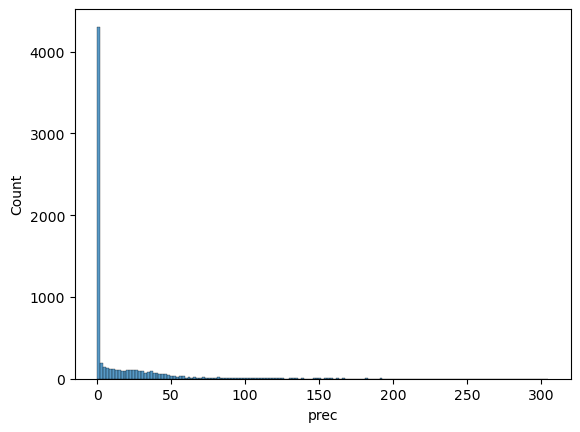

In [25]:
df_temp = pd.melt(df, id_vars=['station id'], value_vars=[str(x) for x in range(1985,2018)],
             var_name='hydro_years', value_name='prec')
df_temp
sn.histplot(data=df_temp,x="prec")